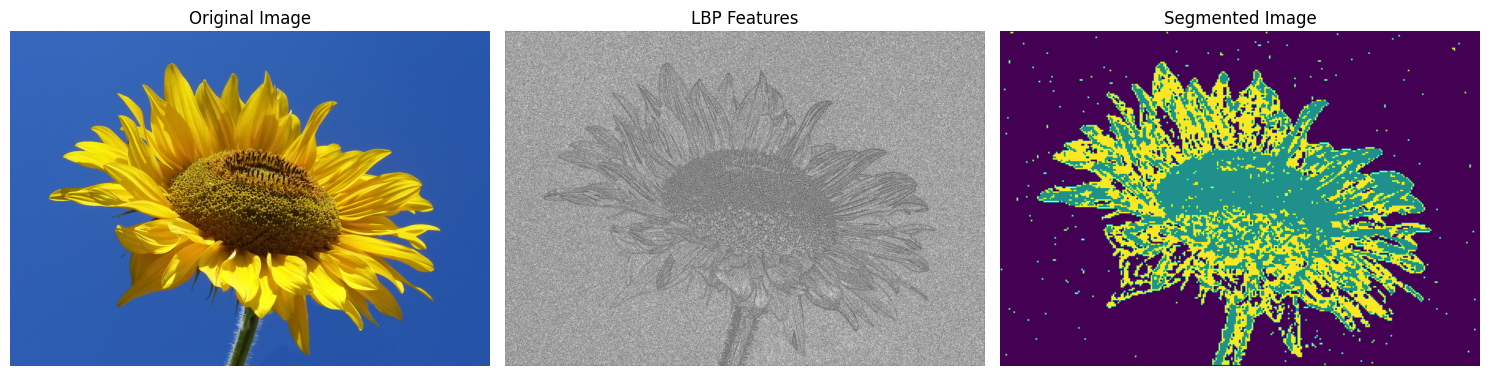

: 

In [ ]:
import numpy as np
import cv2
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
from skimage import io
import warnings
warnings.filterwarnings('ignore')

def compute_lbp(image, P=8, R=1, method='uniform'):
    """
    Compute Local Binary Pattern features for an image
    
    Parameters:
    -----------
    image : array_like
        Input image (grayscale)
    P : int
        Number of circularly symmetric neighbor points
    R : int
        Radius of circle
    method : str
        The method to determine the pattern ('uniform', 'default', 'ror', 'var')
    
    Returns:
    --------
    lbp : array_like
        LBP feature image
    """
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    lbp = local_binary_pattern(image, P, R, method)
    return lbp

def create_lbp_histogram(lbp_image, num_points=8):
    """
    Create histogram of LBP features
    """
    n_bins = num_points + 2
    hist, _ = np.histogram(lbp_image.ravel(), bins=n_bins, range=(0, n_bins))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    return hist

def segment_texture(image, window_size=16, n_clusters=3):
    """
    Segment image based on texture using LBP features
    
    Parameters:
    -----------
    image : array_like
        Input image
    window_size : int
        Size of sliding window for local feature computation
    n_clusters : int
        Number of texture segments to create
    
    Returns:
    --------
    segments : array_like
        Segmented image where each pixel value represents its cluster
    """
    # Compute LBP for entire image
    lbp_image = compute_lbp(image)
    
    # Initialize feature array
    h, w = image.shape[:2]
    features = []
    positions = []
    
    # Slide window over image
    for i in range(0, h-window_size, window_size//2):
        for j in range(0, w-window_size, window_size//2):
            # Extract window
            window = lbp_image[i:i+window_size, j:j+window_size]
            
            # Compute histogram for window
            hist = create_lbp_histogram(window)
            
            # Store features and positions
            features.append(hist)
            positions.append((i + window_size//2, j + window_size//2))
    
    # Cluster the features
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(features)
    
    # Create segmentation map
    segments = np.zeros((h, w), dtype=np.uint8)
    for pos, cluster in zip(positions, clusters):
        i, j = pos
        segments[i-window_size//4:i+window_size//4, 
                j-window_size//4:j+window_size//4] = cluster * 85
    
    return segments

def plot_results(original, lbp, segments):
    """
    Plot original image, LBP features, and segmentation results
    """
    plt.figure(figsize=(15, 5))
    
    plt.subplot(131)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(132)
    plt.imshow(lbp, cmap='gray')
    plt.title('LBP Features')
    plt.axis('off')
    
    plt.subplot(133)
    plt.imshow(segments, cmap='viridis')
    plt.title('Segmented Image')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage
def main():
    # Load image
    image = cv2.imread('..\Q2\image.jpg')
    if image is None:
        raise ValueError("Could not load image")
    
    # Compute LBP features
    lbp = compute_lbp(image)
    
    # Perform segmentation
    segments = segment_texture(image)
    
    # Display results
    plot_results(image, lbp, segments)

# Run the example if in a notebook
if __name__ == '__main__':
    main()